In [21]:
import cv2
import math
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

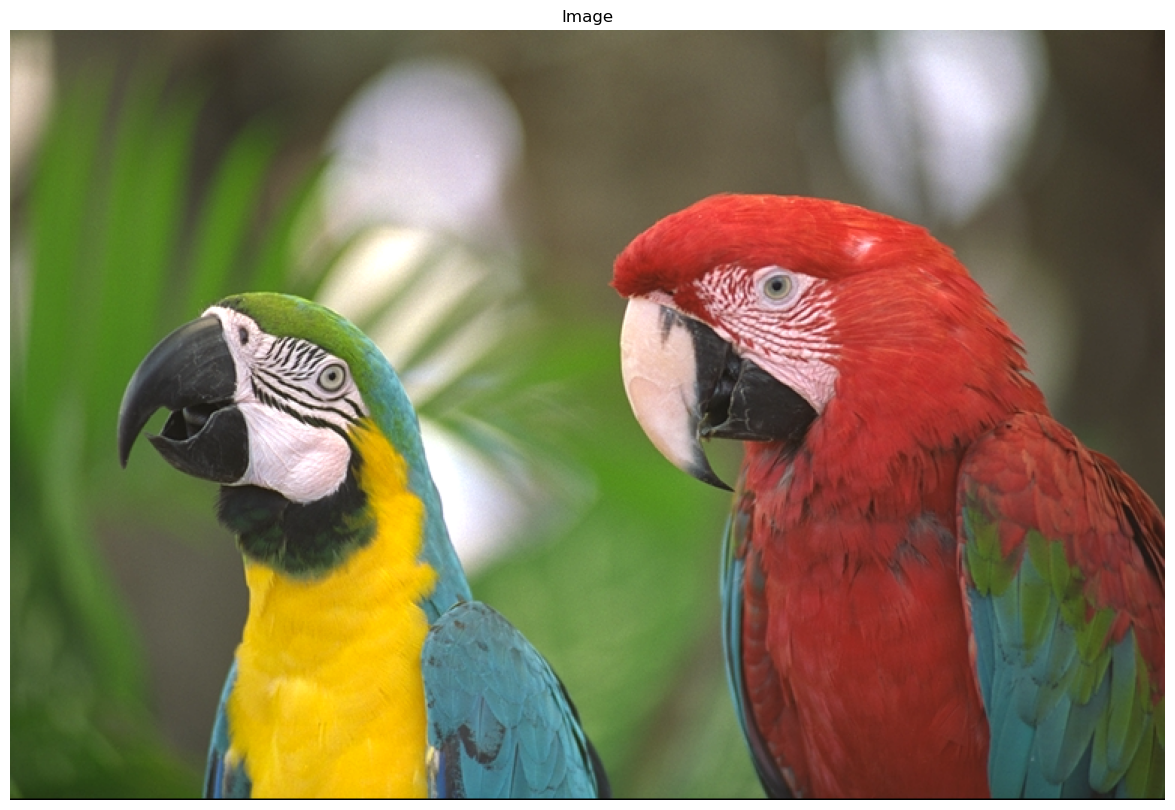

Image shape: (512, 768, 3)


In [22]:
# Load image
img = cv2.imread('data/kodim23.png')
# Convert it to RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title('Image')
plt.axis('off')
plt.show()

print(f"Image shape: {img.shape}")

In [23]:
# COLOR PALETTE 
# Black, dark gray, light gray, white
colors = np.array([[0, 0, 0], #Black
                   [64, 64, 64], #Dark gray
                   [192, 192, 192],#Light gray
                   [255, 255, 255]]) # White

print(f"Palette colors: {colors}")

Palette colors: [[  0   0   0]
 [ 64  64  64]
 [192 192 192]
 [255 255 255]]


In [24]:
# Quantization
# Cast the image to float
img = img.astype(np.float32)

# Prepare for quantization
rows, cols, channels = img.shape
quantized = np.zeros_like(img)

# Apply quantization
for r in range(rows):
    for c in range(cols):
        # Extract the original pixel value
        pixel = img[r, c, :]
        
        # Find the closest colour from the palette using Euclidean distance
        distances = np.sqrt(np.sum((colors - pixel) ** 2, axis=1))
        closest_idx = np.argmin(distances)
        new_pixel = colors[closest_idx]
        
        # Apply quantization
        quantized[r, c, :] = new_pixel

print("Quant.. Completed")

Quant.. Completed


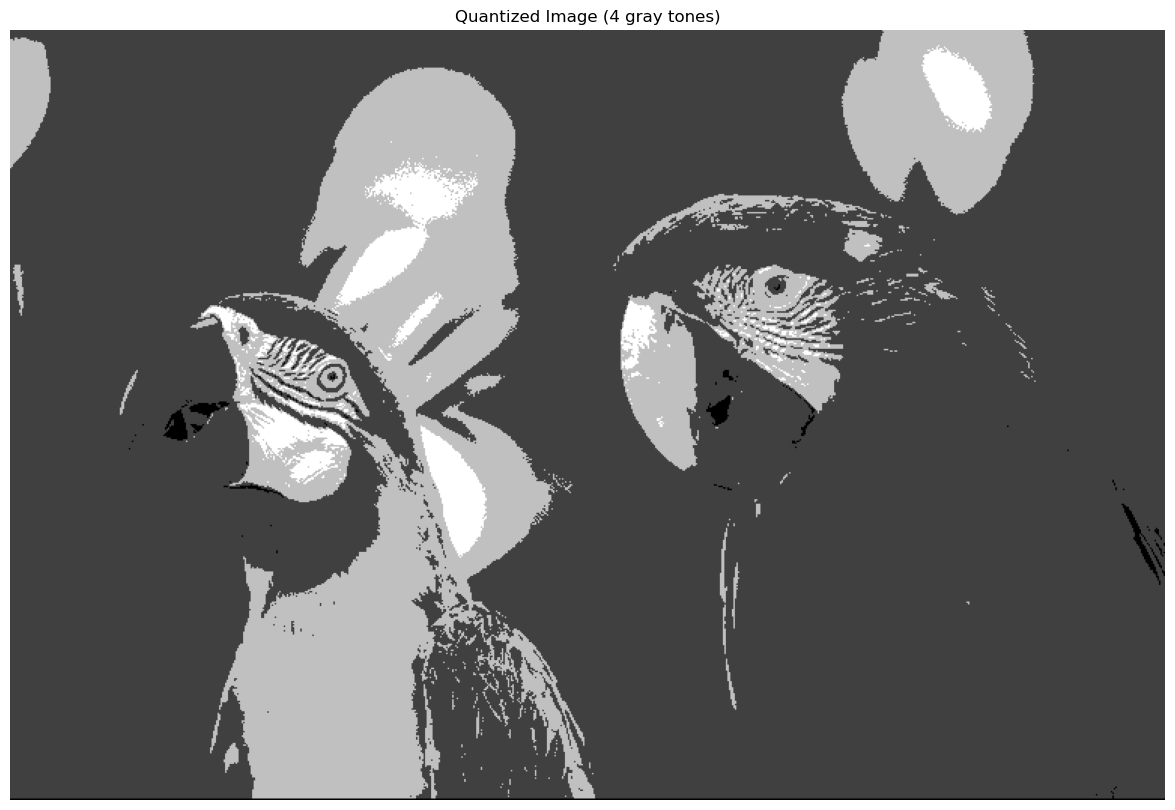

In [25]:
# Show quantization and cast back to uint8
plt.imshow(quantized.astype(np.uint8))
plt.title('Quantized Image (4 gray tones)')
plt.axis('off')
plt.show()

In [26]:
# Compute average quantization error
avg_quant_error = np.mean(np.abs(img - quantized))
print(f" Average quantization error: {avg_quant_error:.4f}")

 Average quantization error: 32.7578


In [27]:
# Floyd-Steinberg Dithering

# Make a temporal copy of the original image for error diffusion
img_tmp = np.copy(img)
dithering = np.zeros_like(img)

for r in range(1, rows-1):
    for c in range(1, cols-1):
        # Extract the current pixel value (with diffused errors)
        pixel = img_tmp[r, c, :]
        
        # Find the closest colour from the palette using Euclidean distance
        distances = np.sqrt(np.sum((colors - pixel) ** 2, axis=1))
        closest_idx = np.argmin(distances)
        new_pixel = colors[closest_idx]
        
        # Compute quantization error
        quant_error = pixel - new_pixel
        
        # Diffuse the quantization error according to FS diffusion matrix
        img_tmp[r,   c+1, :] += quant_error * 7/16  # Right
        img_tmp[r+1, c-1, :] += quant_error * 3/16  # Bottom-left
        img_tmp[r+1, c,   :] += quant_error * 5/16  # Bottom
        img_tmp[r+1, c+1, :] += quant_error * 1/16  # Bottom-right
        
        # Apply dithering
        dithering[r, c, :] = new_pixel

print("Floyd-Steinberg dithering completed!")

Floyd-Steinberg dithering completed!


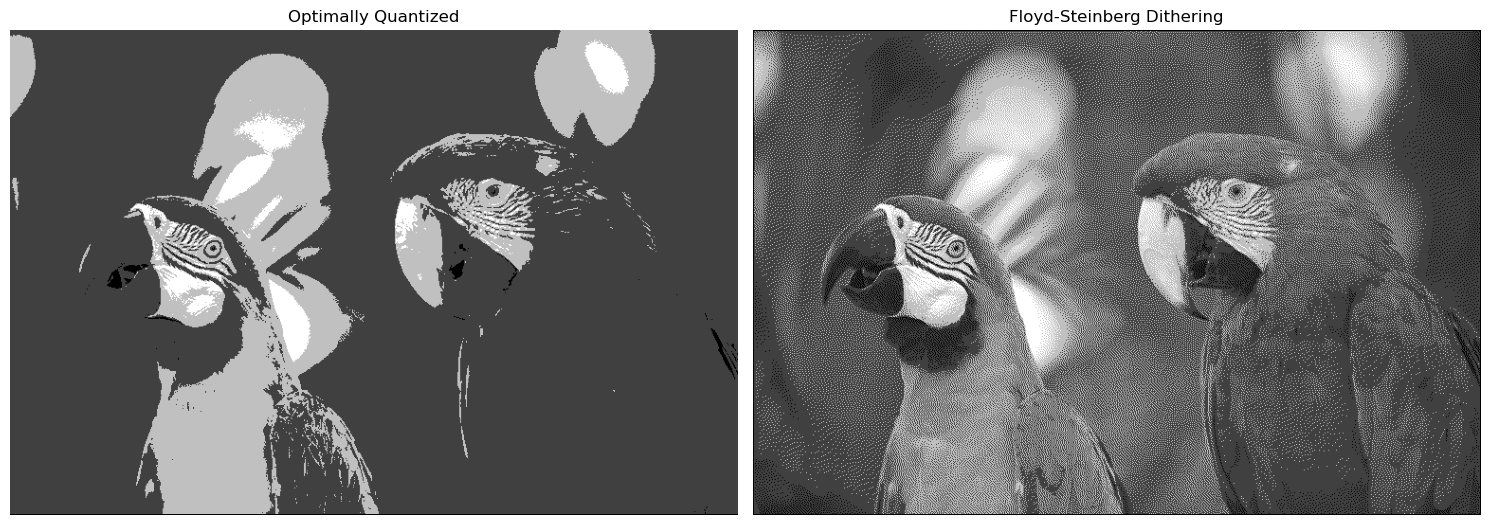

In [28]:
# Show both images for comparison
plt.subplot(121)
plt.imshow(quantized.astype(np.uint8))
plt.title('Optimally Quantized')
plt.axis('off')

plt.subplot(122)
plt.imshow(dithering.astype(np.uint8))
plt.title('Floyd-Steinberg Dithering')
plt.axis('off')

plt.tight_layout()
plt.show()

In [29]:
# Compute average quantization error for dithered image
avg_dith_error = np.mean(np.abs(img - dithering))
print(f"Average quantization error (dithered):   {avg_dith_error:.4f}")

Average quantization error (dithered):   41.8317


In [30]:
# Showing you only black and white

colors_bw = np.array([[0, 0, 0], #Black
                #   [64, 64, 64], #Dark gray
                #   [192, 192, 192],#Light gray
                   [255, 255, 255]]) # White
print(f"B/W: {colors}")

B/W: [[  0   0   0]
 [ 64  64  64]
 [192 192 192]
 [255 255 255]]


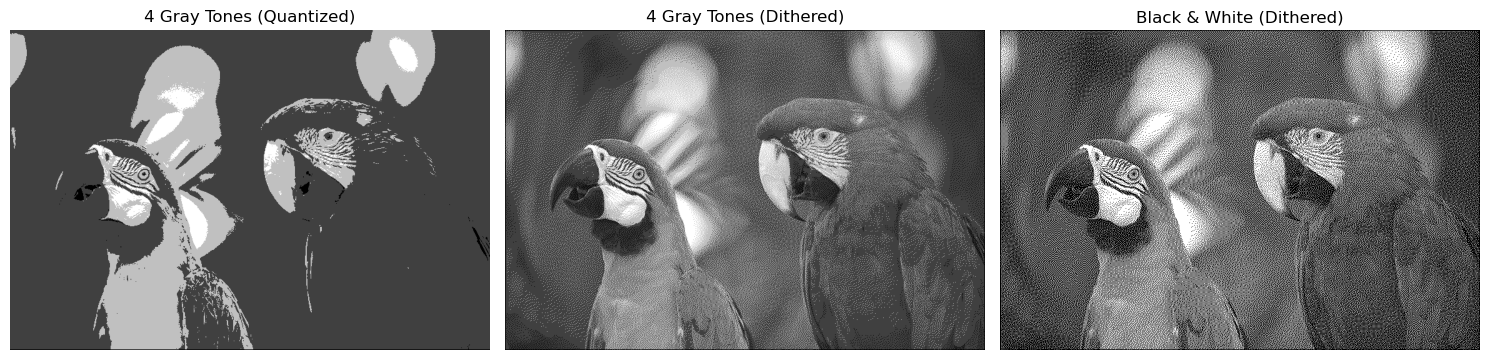

B&W dithering done


In [31]:
img_tmp_bw = np.copy(img)
dithering_bw = np.zeros_like(img)

for r in range(1, rows-1):
    for c in range(1, cols-1):
        pixel = img_tmp_bw[r, c, :]
        
        distances = np.sqrt(np.sum((colors_bw - pixel) ** 2, axis=1))
        closest_idx = np.argmin(distances)
        new_pixel = colors_bw[closest_idx]
        
        quant_error = pixel - new_pixel
        
        img_tmp_bw[r,   c+1, :] += quant_error * 7/16
        img_tmp_bw[r+1, c-1, :] += quant_error * 3/16
        img_tmp_bw[r+1, c,   :] += quant_error * 5/16
        img_tmp_bw[r+1, c+1, :] += quant_error * 1/16
        
        dithering_bw[r, c, :] = new_pixel

plt.subplot(131)
plt.imshow(quantized.astype(np.uint8))
plt.title('4 Gray Tones (Quantized)')
plt.axis('off')

plt.subplot(132)
plt.imshow(dithering.astype(np.uint8))
plt.title('4 Gray Tones (Dithered)')
plt.axis('off')

plt.subplot(133)
plt.imshow(dithering_bw.astype(np.uint8))
plt.title('Black & White (Dithered)')
plt.axis('off')

plt.tight_layout()
plt.show()

print("B&W dithering done")

Image shape: (154, 230, 3)
K-means palette: 16 colors
Dithering completed!


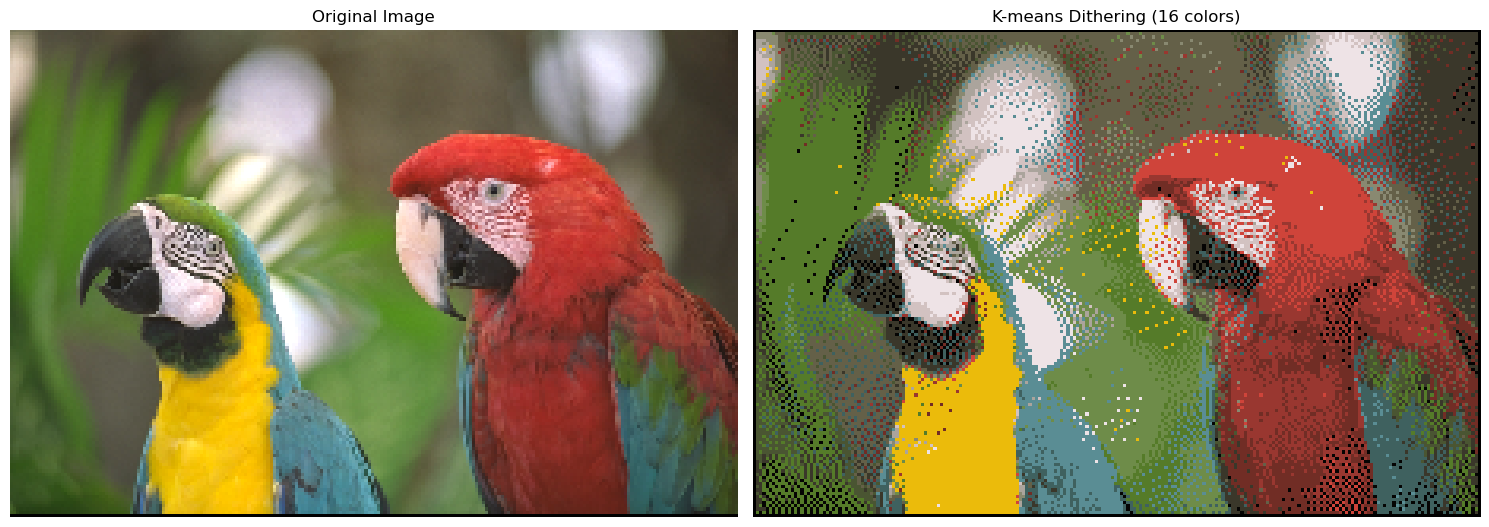

Average error: 16.4243


In [46]:
# Bones K-means

import cv2
import numpy as np
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
plt.rcParams['figure.figsize'] = [15, 10]

# Load image
img = cv2.imread('data/kodim23.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Resize Image to speed-up calculation
img = cv2.resize(img, None, fx=0.3, fy=0.3)
img = img.astype(np.float32)

rows, cols, channels = img.shape
print(f"Image shape: {img.shape}")

# K-MEANS PALETTE (16 colors)
kmeans = KMeans(n_clusters=16, random_state=42, n_init=10).fit(
    np.reshape(img, (-1, 3))
)
colors = kmeans.cluster_centers_
print(f"K-means palette: {len(colors)} colors")

# FLOYD-STEINBERG DITHERING 
img_tmp = np.copy(img)
dithering = np.zeros_like(img)

for r in range(1, rows-1):
    for c in range(1, cols-1):
        pixel = img_tmp[r, c, :]
        
        # Find closest color from palette
        distances = np.sqrt(np.sum((colors - pixel) ** 2, axis=1))
        new_pixel = colors[np.argmin(distances)]
        
        # Compute and diffuse quantization error
        quant_error = pixel - new_pixel
        img_tmp[r,   c+1, :] += quant_error * 7/16
        img_tmp[r+1, c-1, :] += quant_error * 3/16
        img_tmp[r+1, c,   :] += quant_error * 5/16
        img_tmp[r+1, c+1, :] += quant_error * 1/16
        
        dithering[r, c, :] = new_pixel

print("Dithering completed!")

# Results
plt.subplot(121)
plt.imshow(img.astype(np.uint8))
plt.title('Original Image')
plt.axis('off')

plt.subplot(122)
plt.imshow(dithering.astype(np.uint8))
plt.title('K-means Dithering (16 colors)')
plt.axis('off')

plt.tight_layout()
plt.show()

# Average error
avg_error = np.mean(np.abs(img - dithering))
print(f"Average error: {avg_error:.4f}")

Image shape: (154, 230, 3)
 16 colors...
16 colors Average error: 16.4243
 32 colors...
 32 colors Average error: 11.8422
 256 colors...
 256 colors Average error: 4.9825


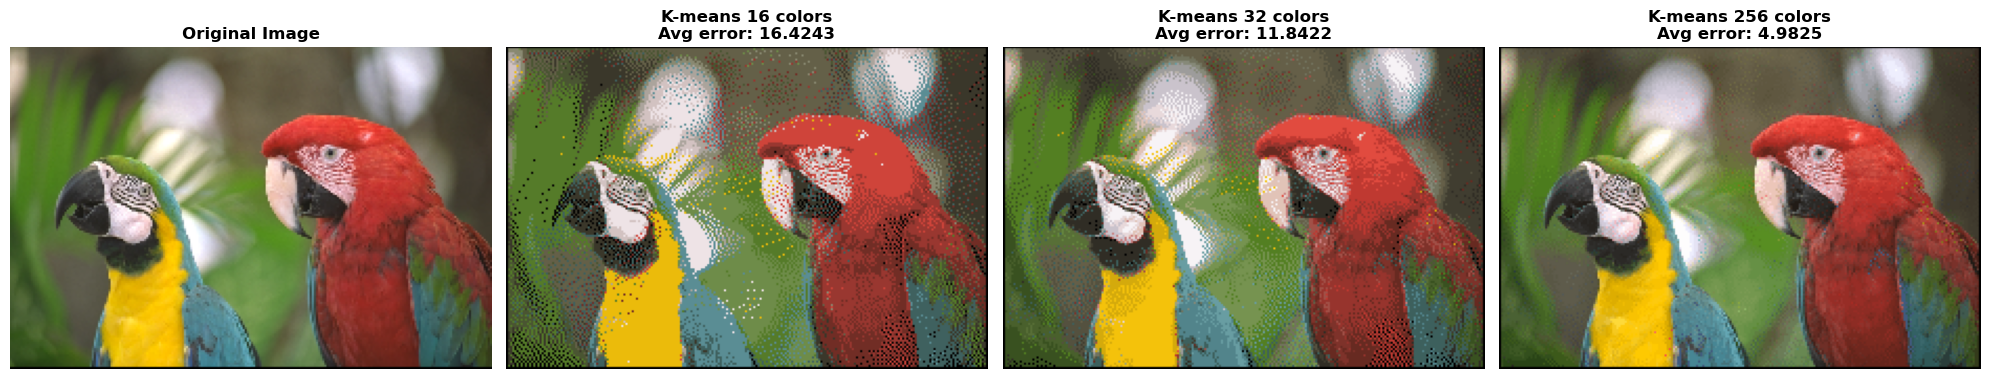


 Compare:
16 colors - Average error: 16.4243
32 colors - Average error: 11.8422
Difference:   4.5821


In [52]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
plt.rcParams['figure.figsize'] = [20, 10]

# Load image
img = cv2.imread('data/kodim23.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, None, fx=0.3, fy=0.3)
img = img.astype(np.float32)

rows, cols, channels = img.shape
print(f"Image shape: {img.shape}")


def fs_dithering(img, colors):
    img_tmp = np.copy(img)
    dithering = np.zeros_like(img)
    rows, cols, _ = img.shape
    
    for r in range(1, rows-1):
        for c in range(1, cols-1):
            pixel = img_tmp[r, c, :]
            
            # Find the closest color from the palette
            distances = np.sqrt(np.sum((colors - pixel) ** 2, axis=1))
            new_pixel = colors[np.argmin(distances)]
            
            # Compute and diffuse quantization error
            quant_error = pixel - new_pixel
            img_tmp[r,   c+1, :] += quant_error * 7/16
            img_tmp[r+1, c-1, :] += quant_error * 3/16
            img_tmp[r+1, c,   :] += quant_error * 5/16
            img_tmp[r+1, c+1, :] += quant_error * 1/16
            
            dithering[r, c, :] = new_pixel
    
    return dithering

#  K-MEANS 16 COLORS 
print(" 16 colors...")
kmeans_16 = KMeans(n_clusters=16, random_state=42, n_init=10).fit(
    np.reshape(img, (-1, 3))
)
dithering_16 = fs_dithering(img, kmeans_16.cluster_centers_)
avg_error_16 = np.mean(np.abs(img - dithering_16))
print(f"16 colors Average error: {avg_error_16:.4f}")

# K-MEANS 32 COLORS 
print(" 32 colors...")
kmeans_32 = KMeans(n_clusters=32, random_state=42, n_init=10).fit(
    np.reshape(img, (-1, 3))
)
dithering_32 = fs_dithering(img, kmeans_32.cluster_centers_)
avg_error_32 = np.mean(np.abs(img - dithering_32))
print(f" 32 colors Average error: {avg_error_32:.4f}")

# K-MEANS 256 COLORS 
print(" 256 colors...")
kmeans_256 = KMeans(n_clusters=256, random_state=42, n_init=10).fit(
    np.reshape(img, (-1, 3))
)
dithering_256 = fs_dithering(img, kmeans_256.cluster_centers_)
avg_error_256 = np.mean(np.abs(img - dithering_256))
print(f" 256 colors Average error: {avg_error_256:.4f}")

# Results
plt.subplot(141)
plt.imshow(img.astype(np.uint8))
plt.title('Original Image', fontsize=12, fontweight='bold')
plt.axis('off')

plt.subplot(142)
plt.imshow(dithering_16.astype(np.uint8))
plt.title(f'K-means 16 colors\nAvg error: {avg_error_16:.4f}', fontsize=12, fontweight='bold')
plt.axis('off')

plt.subplot(143)
plt.imshow(dithering_32.astype(np.uint8))
plt.title(f'K-means 32 colors\nAvg error: {avg_error_32:.4f}', fontsize=12, fontweight='bold')
plt.axis('off')

plt.subplot(144)
plt.imshow(dithering_256.astype(np.uint8))
plt.title(f'K-means 256 colors\nAvg error: {avg_error_256:.4f}', fontsize=12, fontweight='bold')
plt.axis('off')

plt.tight_layout()
plt.show()

print(f"\n Compare:")
print(f"16 colors - Average error: {avg_error_16:.4f}")
print(f"32 colors - Average error: {avg_error_32:.4f}")
print(f"Difference:   {avg_error_16 - avg_error_32:.4f}")